In [4]:
from pathlib import Path

cam_data = Path('../../data/pyronear_cam_data')

In [ ]:
import pandas as pd
from PIL import Image

df = pd.read_csv(cam_data / 'API_DATA - devices.csv')
device = df[df.id == 5].squeeze()
device

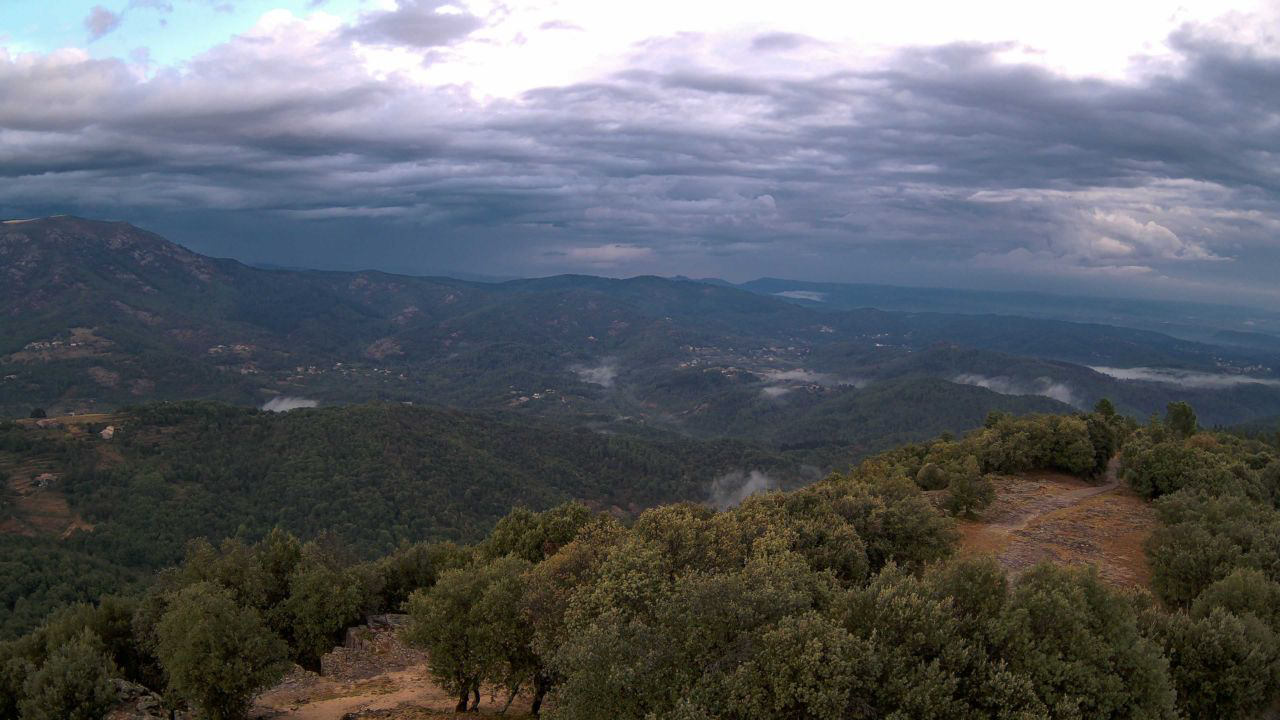

In [7]:
img_path = list((cam_data / device.login).glob('*.jpg'))[11]
img = Image.open(img_path)
img

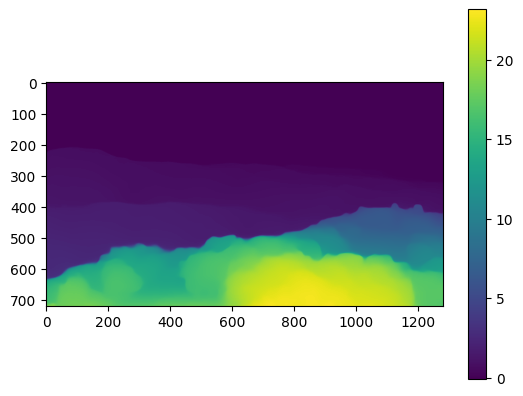

In [4]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import matplotlib.pyplot as plt

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

inputs = image_processor(images=img, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=img.size[::-1],
    mode="bicubic",
    align_corners=False,
)

depth = prediction.squeeze().cpu().numpy()
plt.imshow(depth)
plt.colorbar()

In [11]:
import math

lat, lon = device.lat, device.lon

def bounds_from_distance(km):
    dlat = (km/2) / 111.11
    dlon = dlat / math.cos(math.radians(lat))
    return [lon - dlon, lat - dlat, lon + dlon, lat + dlat]

bounds = bounds_from_distance(50)

In [ ]:
import elevation as eio

eio.clip(bounds=bounds, output=Path.cwd() / 'dem.tiff', product='SRTM3')

In [7]:
import contextily as cx

_ = cx.bounds2raster(*bounds, 'satellite.tiff', ll=True, source=cx.providers.Esri.WorldImagery)

In [ ]:
import rioxarray
from rasterio.crs import CRS

crs = CRS.from_dict(proj='tmerc', ellps='WGS84', lat_0=lat, lon_0=lon) #metric CRS centered on the camera

dem = rioxarray.open_rasterio('dem.tiff')
dem = dem.rio.reproject(crs)
dem = dem.rio.interpolate_na()

sat = rioxarray.open_rasterio('satellite.tiff')
sat = sat.rio.reproject(crs)
sat = sat.rio.clip_box(*dem.rio.bounds())

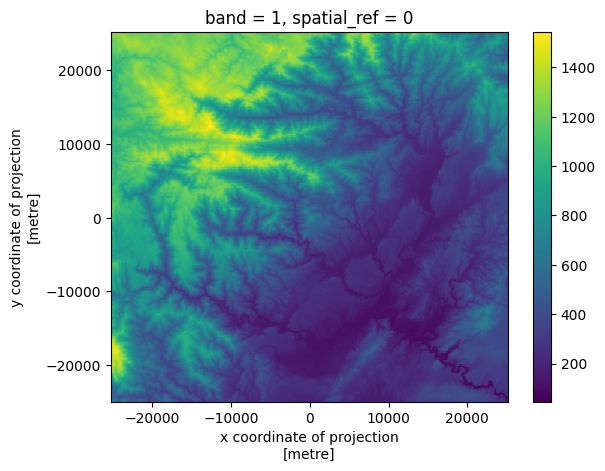

In [9]:
dem.plot()

In [10]:
meter_bounds = dem.rio.bounds()
x_spacing = (meter_bounds[2] - meter_bounds[0]) / dem.rio.shape[0]
y_spacing = (meter_bounds[3] - meter_bounds[1]) / dem.rio.shape[1]

In [11]:
import numpy as np

def get_direction_vector(azimuth, pitch, length=1):
    return np.array([
        length*math.sin(math.radians(azimuth)),
        length*math.cos(math.radians(azimuth)),
        device.elevation - length*math.sin(math.radians(pitch)),
    ])

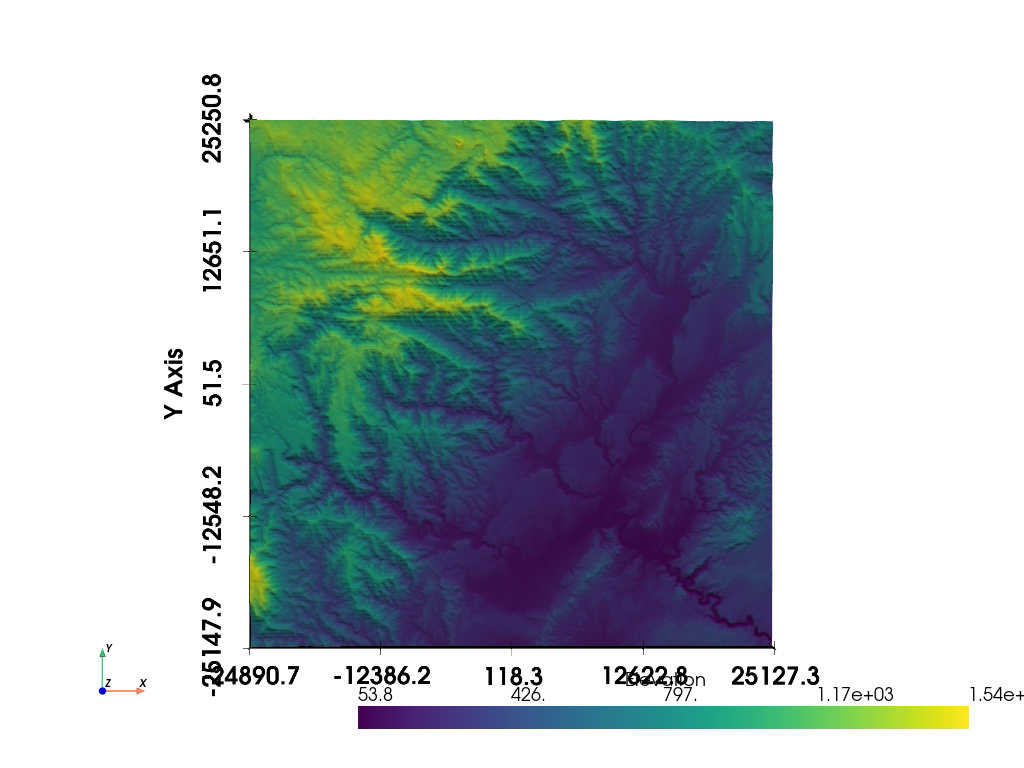

In [12]:
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')

arr = dem.to_numpy().transpose((1, 2, 0))
grid = pv.ImageData(
    dimensions = np.array(arr.shape) + 1,
    spacing=(x_spacing, y_spacing, 0),
    origin=(meter_bounds[0], meter_bounds[1], 0)
)
grid.cell_data["Elevation"] = arr.flatten(order='F') # Flatten the array
terrain = grid.ctp().warp_by_scalar("Elevation")
terrain.rotate_z(-90, inplace=True)
terrain.plot(show_grid=True, cpos='xy')

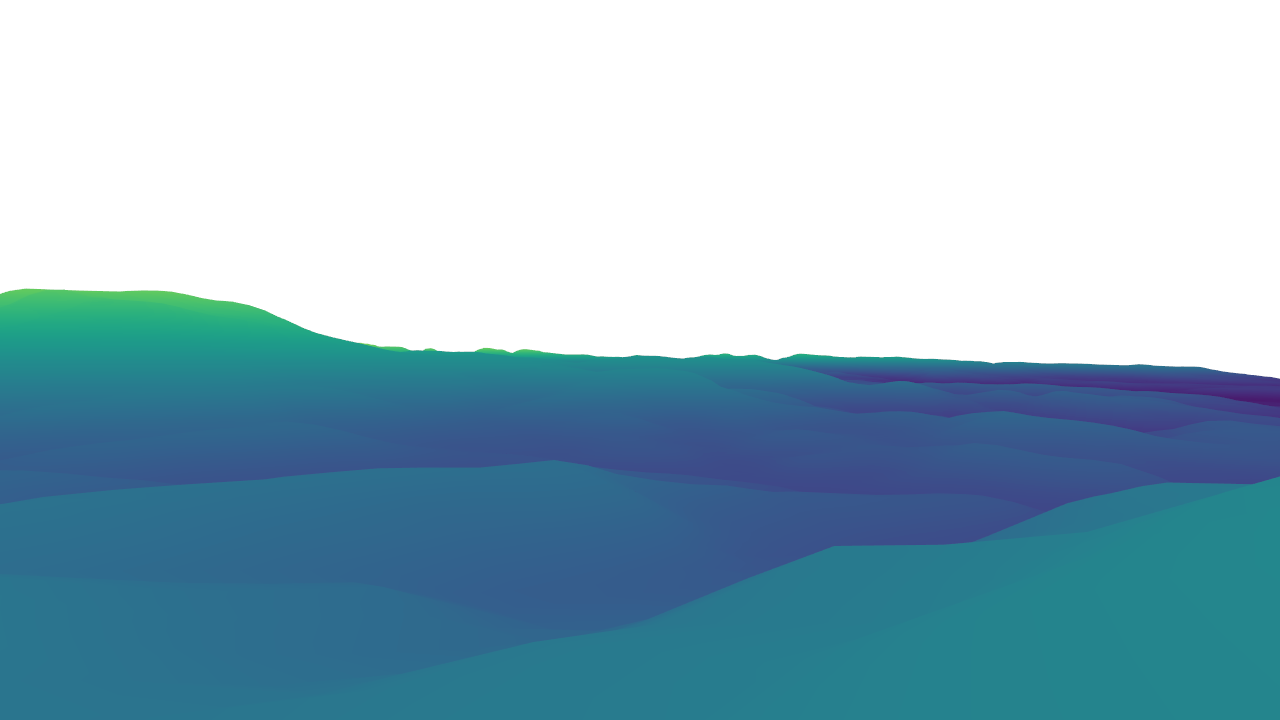

In [23]:
pv.set_jupyter_backend('static')

(w, h) = img.size
vertical_angle_of_view = device.angle_of_view * h / w

camera = pv.Camera()
camera.clipping_range = (30, 1e5)
camera.position = (0, 0, device.elevation)
camera.focal_point = (0, 1, device.elevation)
camera.view_angle = vertical_angle_of_view
camera.up = (0, 0, 1)
camera.Azimuth(-device.azimuth)
camera.Elevation(device.pitch)

pl = pv.Plotter(window_size=(w, h), lighting=None)
pl.camera = camera
pl.add_mesh(terrain)
pl.remove_scalar_bar()
pl.show()
zval = pl.get_image_depth(fill_value=None)

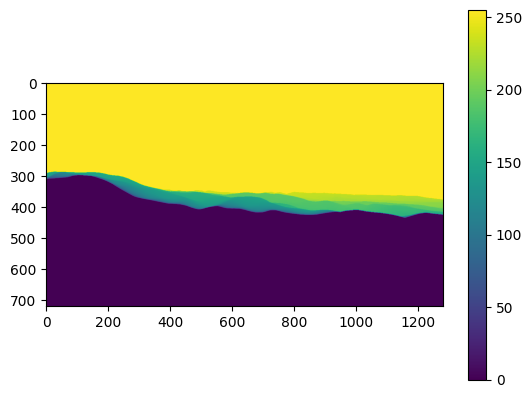

In [16]:
import matplotlib.pyplot as plt

true_depth = np.log(np.maximum(-zval, 4000) - 3999)
true_depth = 255 * true_depth / true_depth.max()
plt.imshow(true_depth)
plt.colorbar()

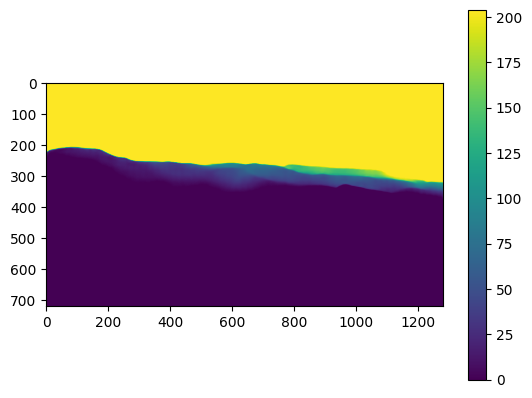

In [17]:
img_depth = 255 * (0.8 - np.clip(depth, 0, 0.8, dtype=np.float32))
plt.imshow(img_depth)
plt.colorbar()

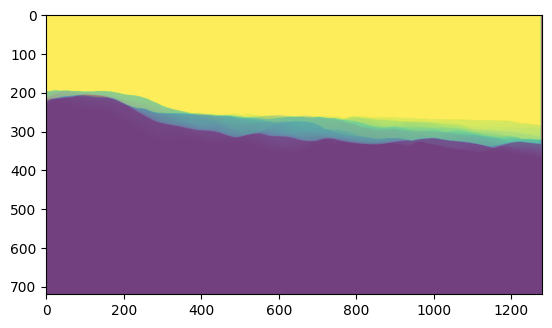

In [18]:
import cv2

criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000, 1e-5)
warp_matrix = np.eye(2, 3, dtype=np.float32)
cv2.findTransformECC(img_depth, true_depth, warp_matrix, cv2.MOTION_TRANSLATION, criteria, None, 5)

true_depth_aligned = cv2.warpAffine(true_depth, warp_matrix, (w, h), flags=cv2.WARP_INVERSE_MAP);
plt.imshow(img_depth, alpha=.5)
plt.imshow(true_depth_aligned, alpha=.5)

In [19]:
azimuth_shift = -warp_matrix[0, 2] / w * device.angle_of_view
pitch_shift = warp_matrix[1, 2] / h * vertical_angle_of_view
roll_shift = math.degrees(math.atan2(warp_matrix[0, 1], warp_matrix[1, 1]))

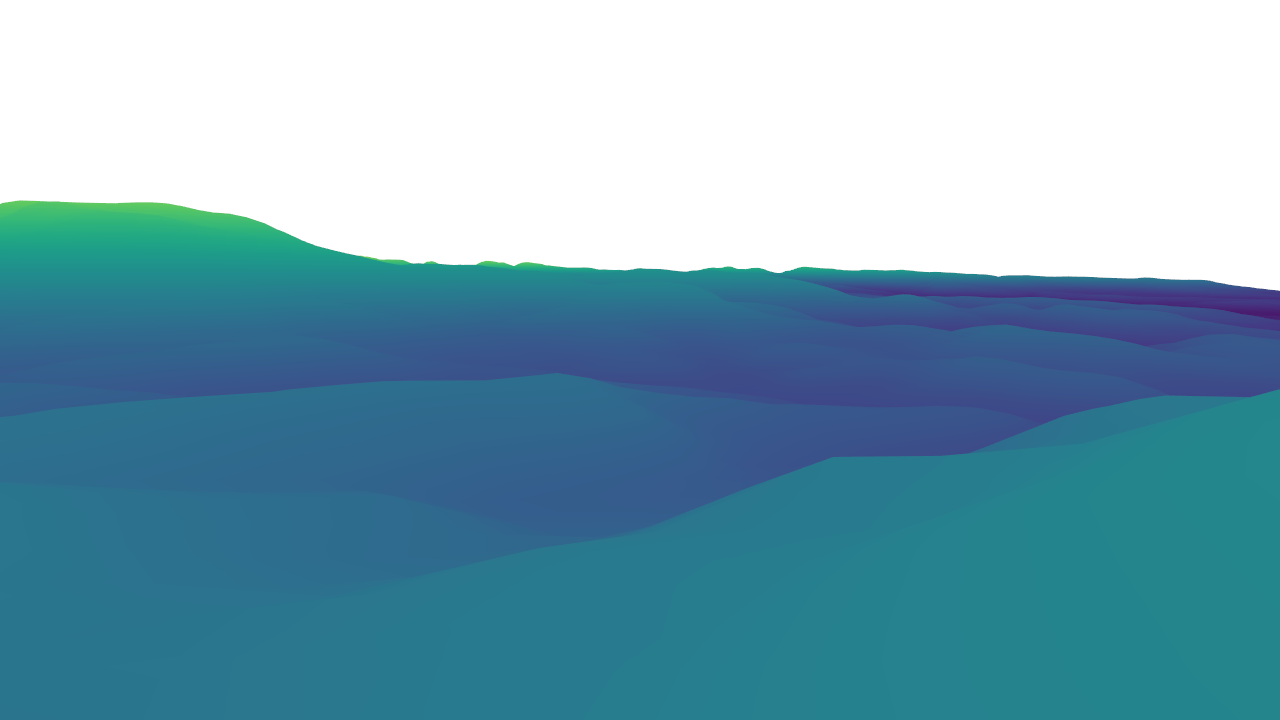

In [27]:
pv.set_jupyter_backend('static')

camera = pv.Camera()
camera.clipping_range = (30, 1e5)
camera.position = (0, 0, device.elevation)
camera.focal_point = (0, 1, device.elevation)
camera.view_angle = vertical_angle_of_view
camera.up = (0, 0, 1)
camera.Azimuth(-(device.azimuth + azimuth_shift))
camera.Elevation(device.pitch + pitch_shift)
camera.Roll(roll_shift)

pl = pv.Plotter(window_size=(w, h), lighting=None)
pl.camera = camera
pl.add_mesh(terrain)
pl.remove_scalar_bar()
pl.show()
zval = pl.get_image_depth()

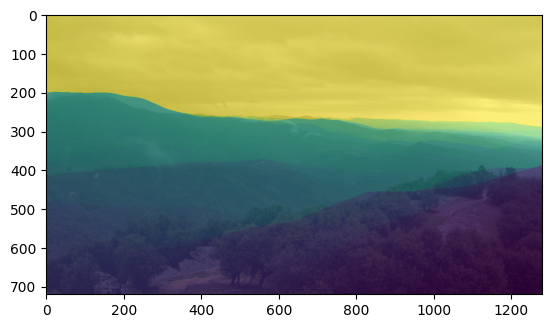

In [28]:
true_depth = np.log(-zval)

plt.imshow(img)
plt.imshow(true_depth, alpha=.6)

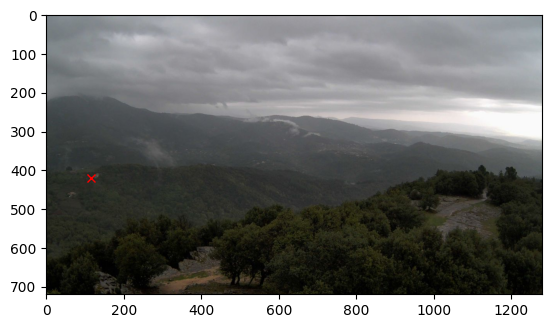

In [29]:
plt.imshow(img)
x, y = 115, 420
plt.plot(x, y, 'rx')

In [30]:
point_azimuth = device.azimuth + azimuth_shift + device.angle_of_view*(x - w/2)/w
point_pitch = device.pitch + pitch_shift + vertical_angle_of_view*(y - h/2)/h

In [31]:
ray_start = (0, 0, device.elevation)
ray_length = 2e3
ray_end = (
    ray_length*math.sin(math.radians(point_azimuth)),
    ray_length*math.cos(math.radians(point_azimuth)),
    device.elevation - ray_length*math.sin(math.radians(point_pitch))
)
point, ind = terrain.extract_surface().ray_trace(ray_start, ray_end, first_point=True)

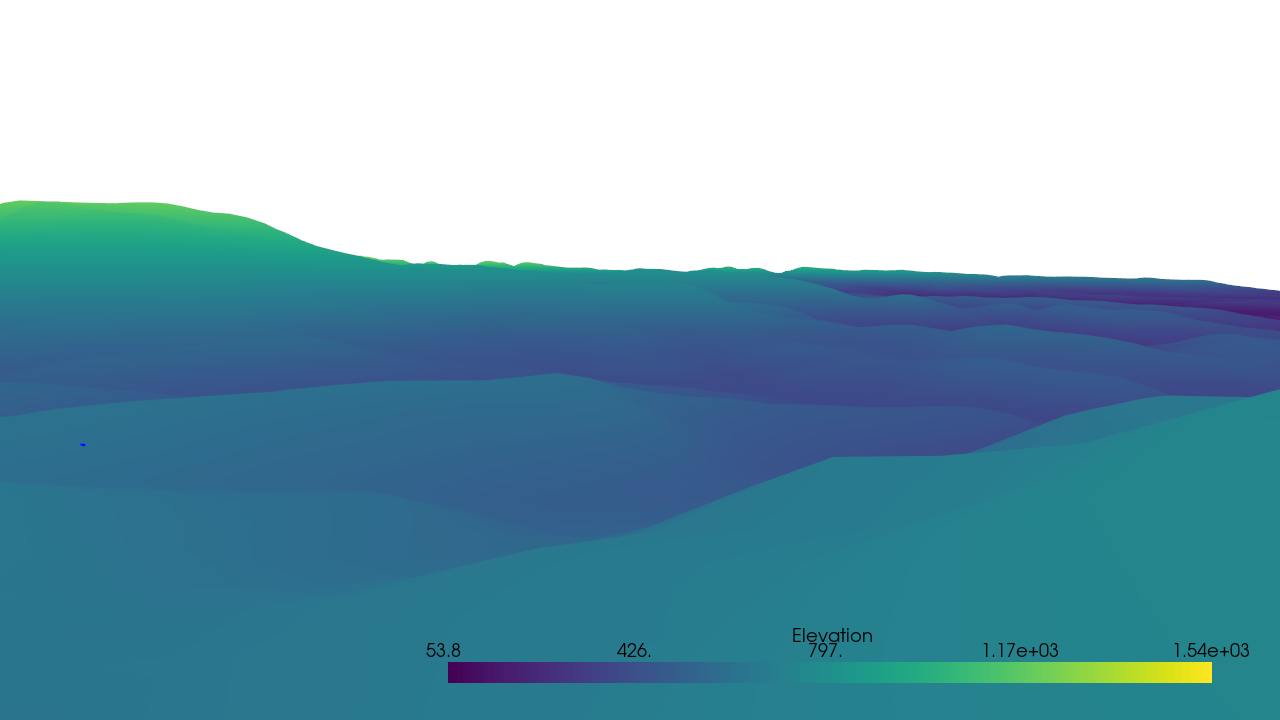

In [33]:
pv.set_jupyter_backend('static')

camera = pv.Camera()
camera.clipping_range = (30, 1e5)
camera.position = (0, 0, device.elevation)
camera.focal_point = (0, 1, device.elevation)
camera.view_angle = vertical_angle_of_view
camera.up = (0, 0, 1)
camera.Azimuth(-(device.azimuth + azimuth_shift))
camera.Elevation(device.pitch + pitch_shift)
camera.Roll(roll_shift)

pl = pv.Plotter(window_size=(w, h), lighting=None)
pl.camera = camera
pl.add_mesh(pv.PolyData(point), color='blue')
pl.add_mesh(terrain)
pl.show()

In [ ]:
import contextily as cx
import pyproj

plt.figure(figsize=(20,10))
bounds = bounds_from_distance(2)
map, ext = cx.bounds2img(*bounds, ll=True, source=cx.providers.Esri.WorldImagery)
plt.imshow(map, extent=ext)
x, y = pyproj.transform("EPSG:4326", "EPSG:3857", lat, lon)
plt.plot(x, y, 'ro')
x, y = pyproj.transform("EPSG:4326", "EPSG:3857", 44.555991, 4.218755)
plt.plot(x, y, 'go')
x, y = pyproj.transform(crs, "EPSG:3857", point[0], point[1])
plt.plot(x, y, 'bo')